# Estudos - Class Weight + Trade Off Decisões

Seguem estudos utilizando famoso dataset da IBM

In [1]:
## bibliotecas

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

linhas, colunas = df.shape
print(f'O dataset tem {linhas} linhas e {colunas} colunas')

df.head()

O dataset tem 1470 linhas e 35 colunas


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
df.nunique().sort_values()

Over18                         1
StandardHours                  1
EmployeeCount                  1
Gender                         2
Attrition                      2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
WorkLifeBalance                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate

## Separando As Features

Precisa ser minimizado os erros de escolhas automatizadas de rotular variáveis numéricas e categóricas.

In [5]:
df.Attrition.value_counts(1)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

In [6]:
## categorical = [col for col in df.columns
##              if df[col].nunique() < 6
##              and col !='Attrition']

## numerical = [col for col in df.columns
##            if df[col].nunique()>=7
##            and col !='Attrition']

numerical = df.select_dtypes(include=[np.number]).columns.tolist()
categorical = df.select_dtypes(exclude=[np.number]).columns.tolist()
categorical = [col for col in categorical if col !='Attrition']

In [7]:
categorical, numerical

(['BusinessTravel',
  'Department',
  'EducationField',
  'Gender',
  'JobRole',
  'MaritalStatus',
  'Over18',
  'OverTime'],
 ['Age',
  'DailyRate',
  'DistanceFromHome',
  'Education',
  'EmployeeCount',
  'EmployeeNumber',
  'EnvironmentSatisfaction',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'MonthlyRate',
  'NumCompaniesWorked',
  'PercentSalaryHike',
  'PerformanceRating',
  'RelationshipSatisfaction',
  'StandardHours',
  'StockOptionLevel',
  'TotalWorkingYears',
  'TrainingTimesLastYear',
  'WorkLifeBalance',
  'YearsAtCompany',
  'YearsInCurrentRole',
  'YearsSinceLastPromotion',
  'YearsWithCurrManager'])

In [8]:
## importando bibliotecas necessárias

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

## Conversão do Target em Dummy

In [9]:
df['Attrition'] = df.Attrition.map({'No': 0, 'Yes': 1})

In [10]:
target = 'Attrition'

X = df[categorical + numerical]

y = df[target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [12]:
from sklearn.utils.class_weight import compute_class_weight ## 2 - segunda etapa para tentar melhorar o modelo - inserindo pesos
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

In [13]:
weights_dict

{0: 0.6012269938650306, 1: 2.9696969696969697}

## Pipeline

In [14]:
numeric_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps = [('encoder', TargetEncoder())])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_classif, k=20)), ## 1 - após rodar inicialmente "sem" - inserindo select KBest para tentar melhorar o modelo
    ('classifier', LogisticRegression(class_weight=weights_dict))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorke...
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime'])])),
                ('select', SelectKBest(k=20)),
                ('classifier',
                 LogisticRegression(class_weight={0: 0.6012269938650306,
                                                  1: 2.9696969696969697}))])

In [24]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score


# Defina a lista de valores de k que você deseja testar
valores_k = [10, 15, 20, 25, 30]

# Crie listas vazias para armazenar os resultados
resultados = []

for k in valores_k:
    # Crie o pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('select', SelectKBest(f_classif, k=k)),
        ('classifier', LogisticRegression(class_weight=weights_dict))
    ])

    # Treine o pipeline
    pipeline.fit(X_train, y_train)

    # Avalie o pipeline usando cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # Use 5-fold cross-validation
    mean_score = np.mean(scores)

    # Armazene os resultados
    resultados.append((k, mean_score))

# Exiba os resultados
for k, score in resultados:
    print(f"Para k={k}, a média dos scores é: {score}")

# Encontre o melhor valor de k baseado nos resultados
melhor_k, melhor_score = max(resultados, key=lambda x: x[1])
print(f"Melhor valor de k encontrado: {melhor_k} com score médio de: {melhor_score}")

Para k=10, a média dos scores é: 0.6317958889289578
Para k=15, a média dos scores é: 0.6258276235124415
Para k=20, a média dos scores é: 0.6598701767039307
Para k=25, a média dos scores é: 0.6360367832672196
Para k=30, a média dos scores é: 0.6199062387306167
Melhor valor de k encontrado: 20 com score médio de: 0.6598701767039307


In [15]:
y_pred = pipeline.predict(X_test)

In [16]:
y_pred

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [17]:
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')

y_pred_proba = pipeline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

Precision: 0.21100917431192662
Recall: 0.5897435897435898
F1: 0.31081081081081086
Acurácia: 0.6530612244897959
ROC AUC: 0.6262443438914027


Precision: 0.21100917431192662
Recall: 0.5897435897435898
F1: 0.31081081081081086
Acurácia: 0.6530612244897959
ROC AUC: 0.6262443438914027

- Das pessoas que o modelo realmente previu que iriam sair da empresa, 21% saíram (precision)
-  De todos que realmente saíram, nosso modelo previu 58,97% (recall)

## 3° Etapa de Melhoria do Modelo - Alteração de Threshold (Limite)

In [18]:
results = []

for thres in np.arange(0.05, 1, 0.05):
    y_pred = (pipeline.predict_proba(X_test)[:, 1]>thres)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    results.append((thres, precision, recall, f1, acc))

In [19]:
results

[(0.05, 0.1326530612244898, 1.0, 0.23423423423423423, 0.1326530612244898),
 (0.1, 0.13732394366197184, 1.0, 0.24148606811145515, 0.16666666666666666),
 (0.15000000000000002,
  0.13503649635036497,
  0.9487179487179487,
  0.2364217252396166,
  0.1870748299319728),
 (0.2,
  0.1423076923076923,
  0.9487179487179487,
  0.24749163879598662,
  0.23469387755102042),
 (0.25,
  0.15086206896551724,
  0.8974358974358975,
  0.25830258302583026,
  0.3163265306122449),
 (0.3,
  0.15813953488372093,
  0.8717948717948718,
  0.2677165354330709,
  0.3673469387755102),
 (0.35000000000000003,
  0.1711229946524064,
  0.8205128205128205,
  0.2831858407079646,
  0.4489795918367347),
 (0.4,
  0.17177914110429449,
  0.717948717948718,
  0.27722772277227725,
  0.5034013605442177),
 (0.45,
  0.19718309859154928,
  0.717948717948718,
  0.3093922651933702,
  0.5748299319727891),
 (0.5,
  0.21100917431192662,
  0.5897435897435898,
  0.31081081081081086,
  0.6530612244897959),
 (0.55,
  0.2289156626506024,
  0.4871

In [20]:
## transformando em um dataframe para ler

results_df = pd.DataFrame(results, columns=['thres', 'precision', 'recall', 'f1', 'acc'])

In [21]:
results_df

,thres,precision,recall,f1,acc
0,0.05,0.132653,1.000000,0.234234,0.132653
1,0.10,0.137324,1.000000,0.241486,0.166667
2,0.15,0.135036,0.948718,0.236422,0.187075
3,0.20,0.142308,0.948718,0.247492,0.234694
4,0.25,0.150862,0.897436,0.258303,0.316327
5,0.30,0.158140,0.871795,0.267717,0.367347
6,0.35,0.171123,0.820513,0.283186,0.448980
7,0.40,0.171779,0.717949,0.277228,0.503401
8,0.45,0.197183,0.717949,0.309392,0.574830
9,0.50,0.211009,0.589744,0.310811,0.653061


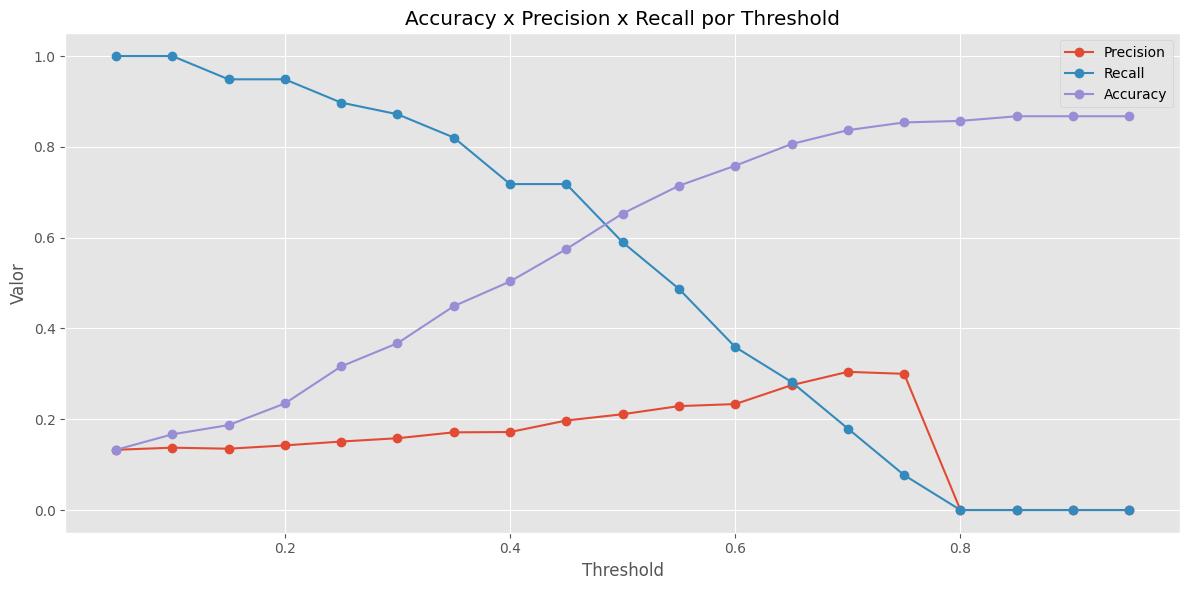

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(results_df['thres'], results_df['precision'], label = 'Precision', marker ='o')
plt.plot(results_df['thres'], results_df['recall'], label = 'Recall', marker ='o')
plt.plot(results_df['thres'], results_df['acc'], label = 'Accuracy', marker ='o')

plt.title('Accuracy x Precision x Recall por Threshold')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()